<a href="https://colab.research.google.com/github/Lord-Kanzler/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS_233_assignment_ALEX_KAISER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] If you haven't completed assignment #1, please do so first.
- [x] Continue to clean and explore your data. Make exploratory visualizations.
- [x] Fit a model. Does it beat your baseline? 
- [x] Try xgboost.
- [x] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

**Same as yesterday, I am working on parameter optimization for my dc-assident data, and am comparing XGboost, adaboost and CV techniques to see what gives the best outcomes for my data. And since those take a while to do on a larger data set, I defer to the cleaned tribeca data set from 232 assignment for todays exercises.**


In [58]:
# Read New York City property sales data
import pandas as pd
import numpy as np
df = pd.read_csv('https://raw.githubusercontent.com/Lord-Kanzler/DS-Unit-2-Applied-Modeling/master/module2-wrangle-ml-datasets/tribeca.csv')
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,222,1013,NaN,R4,"181 HUDSON STREET, 6D",6D,10013.0,1.0,0.0,1.0,"7,878",1840.0,1909.0,2,R4,2800000,2019-01-03
1,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,9022,NaN,R4,"10 LITTLE WEST STREET, 19A",19A,10004.0,1.0,0.0,1.0,0,1759.0,0.0,2,R4,2650000,2019-01-07
2,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,1441,NaN,R4,"30 LITTLE WEST STREET, 7G",7G,10004.0,1.0,0.0,1.0,0,1190.0,2005.0,2,R4,1005000,2019-01-09
3,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,3624,NaN,R4,"2 RIVER TERRACE, 4C",4C,0.0,1.0,0.0,1.0,0,1088.0,2006.0,2,R4,1678000,2019-01-10
4,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,2610,NaN,R4,"380 RECTOR PLACE, 10A",10A,10280.0,1.0,0.0,1.0,0,873.0,0.0,2,R4,1380000,2019-01-11


In [0]:
df.drop('EASE-MENT', axis=1, inplace=True)

In [60]:
# install
!pip install category_encoders==2.*
!pip install eli5

In [0]:
# train/test/val split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, random_state=1984)
train, val = train_test_split(train, random_state=1984)

In [62]:
# Arrange data into X features matrix and y target vector
target = 'SALE_PRICE'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
X_train.shape, X_val.shape, X_test.shape

((50, 19), (17, 19), (23, 19))

In [63]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT                int64
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [64]:
# fit model
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', -pipeline.score(X_val, y_val))

k = 10
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

Validation Accuracy 0.5631491193346565
MAE for 10 folds: [ 987819.55  1405476.256 1100513.254  634134.264  960572.524  660523.102
 2106846.644  939584.886  889759.086 1975285.488]


In [65]:
-scores.mean()

1166051.5054

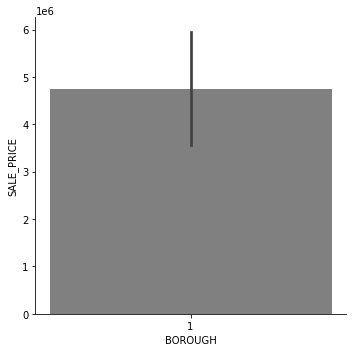

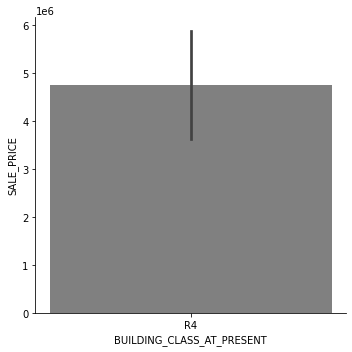

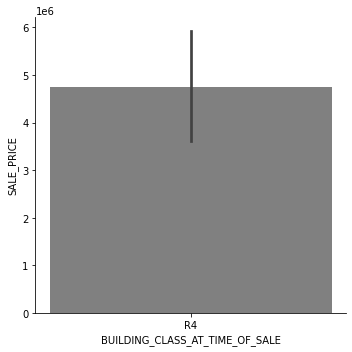

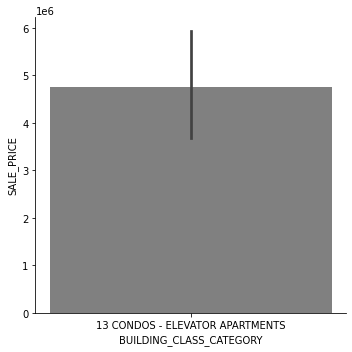

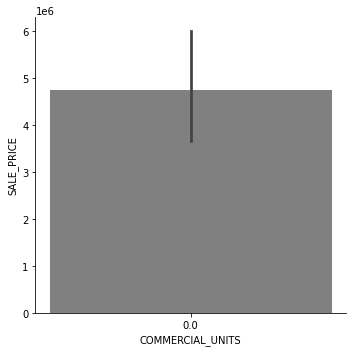

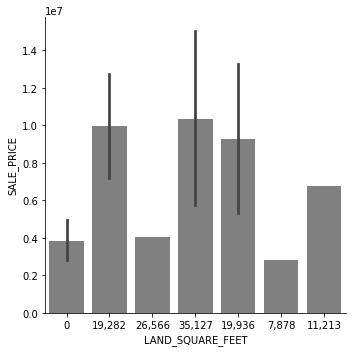

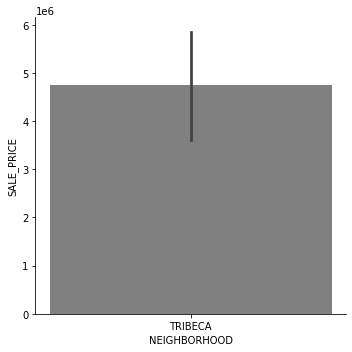

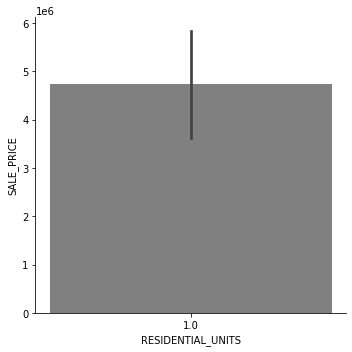

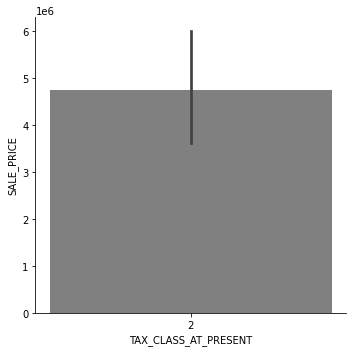

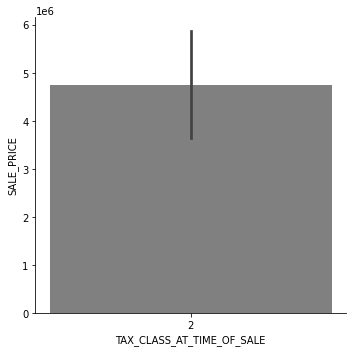

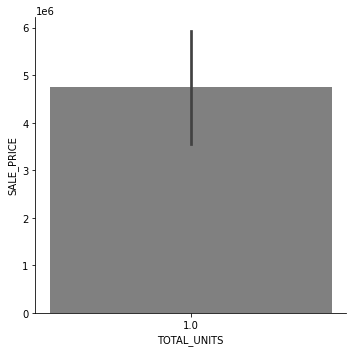

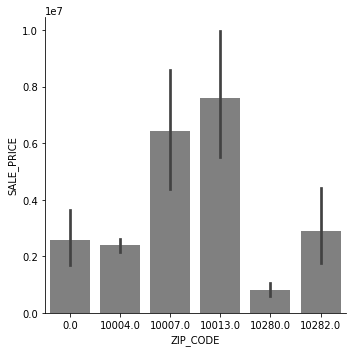

In [66]:
# plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in sorted(train.columns):
    if train[col].nunique() < 10:
        try:
            sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
            plt.show()
        except:
            pass

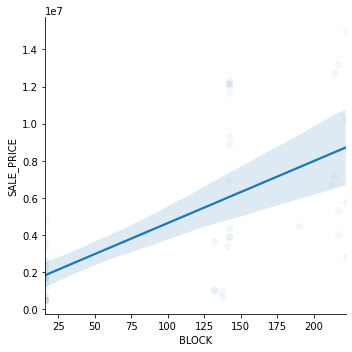

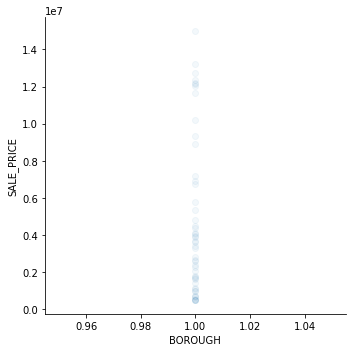

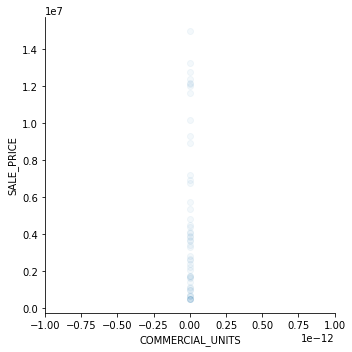

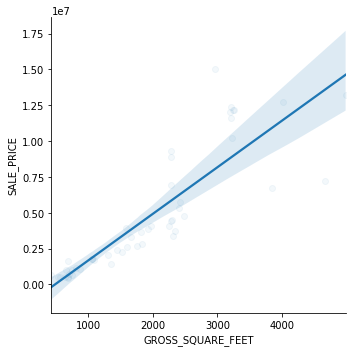

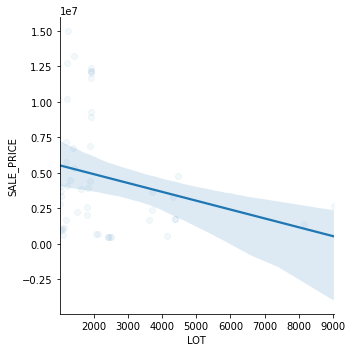

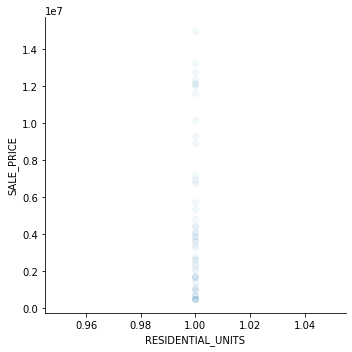

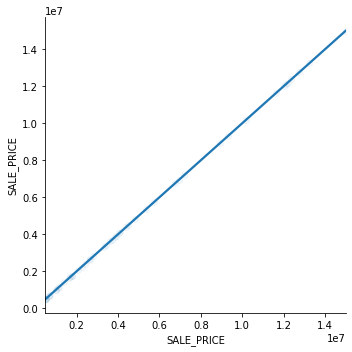

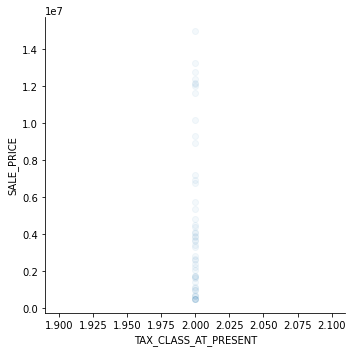

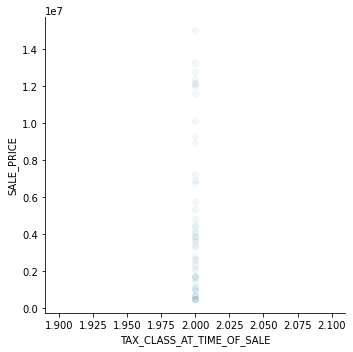

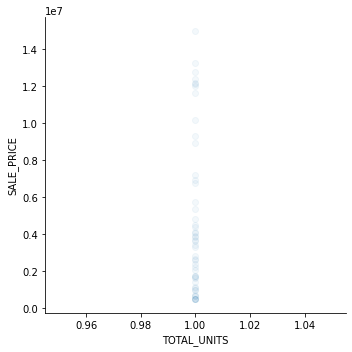

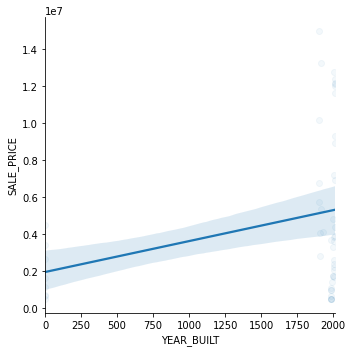

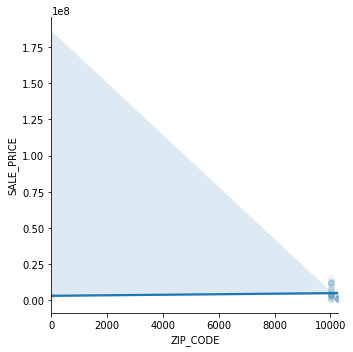

In [67]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

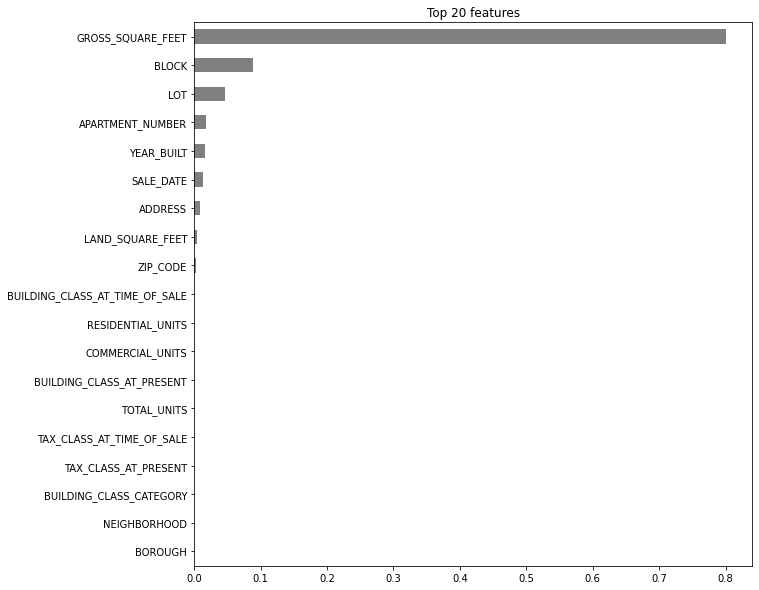

In [68]:
# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [69]:
column  = 'GROSS_SQUARE_FEET'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = -pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without GROSS_SQUARE_FEET: -3.0801261920425484
Validation Accuracy with GROSS_SQUARE_FEET: 0.5631491193346565
Drop-Column Importance for GROSS_SQUARE_FEET: 3.643275311377205


**These values don't make sense, but not really relevant**

In [70]:
# permutation importances

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean') 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [71]:
%%time
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=10,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

CPU times: user 3.7 s, sys: 911 ms, total: 4.61 s
Wall time: 19.6 s


In [72]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_test.columns.to_list()
)

Weight,Feature
988341.8118 ± 544827.4073,GROSS_SQUARE_FEET
119071.6112 ± 141674.0850,LOT
76120.3805 ± 57589.2870,BLOCK
6427.8774 ± 29897.5680,YEAR_BUILT
0 ± 0.0000,BOROUGH
0 ± 0.0000,BUILDING_CLASS_AT_TIME_OF_SALE
0 ± 0.0000,TAX_CLASS_AT_PRESENT
0 ± 0.0000,BUILDING_CLASS_AT_PRESENT
0 ± 0.0000,ADDRESS
0 ± 0.0000,RESIDENTIAL_UNITS


In [73]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print ('Validation accuracy', accuracy_score(y_val, y_pred))

#to compare with accuracy_score
# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))


Validation accuracy 0.0
Validation Accuracy 0.0


**GREAT** **:(**

**at least it's working for locally on on my project data.**